# Using Inception v3 model for image recognition

## Import packages

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import time
from datetime import timedelta

/Users/jiangming/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# load the modules developed by Magnus Erik Hvass Pedersen
import inception  # details see inception.py
import knifey     # details see knifey.py 

# load dateset

In [3]:
from knifey import num_classes

In [4]:
# define the data_dir to store the data
knifey.data_dir = "data/knifey-spoony/"
data_dir        =knifey.data_dir

In [5]:
knifey.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


In [6]:
# load data into memory
dataset = knifey.load()

Creating dataset from the files in: data/knifey-spoony/
- Data loaded from cache-file: data/knifey-spoony/knifey-spoony.pkl


In [7]:
# class_names is defined using the directory name in the dataset, see dataset.py
class_names=dataset.class_names 

In [8]:
print(class_names)

['forky', 'knifey', 'spoony']


## get information about the dataset

Training dataset:
- img_path_train: get the paths for all the 4170 training images
- cls_train(4170): get the class numbers (totally three classes: 0, 1, or 2) for all the 4170 training images 
- labels_train(4170, 3): get the labels using np.eye(num_classes, dtype=float)[class_numbers]

Test dataset:
- img_path_train: get the paths for all the 530 test images
- cls_train(530): get the class numbers (totally three classes: 0, 1, or 2) for all the test images 
- labels_train(530, 3): 

In [9]:
image_paths_train,cls_train,labels_train=dataset.get_training_set() 

# see dataset.py for details of get_training_set(), which returns a list as below
#list(self.get_paths()),np.asarray(self.class_numbers),one_hot_encoded(class_numbers=self.class_numbers,num_classes=self.num_classes)

In [10]:
image_paths_test,cls_test,labels_test=dataset.get_test_set() 
labels_test.shape

(530, 3)

# Help function

In [11]:
from matplotlib.image import imread
def load_images(image_paths):
    images=[imread(path) for path in image_paths]
    return np.asarray(images)


def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    

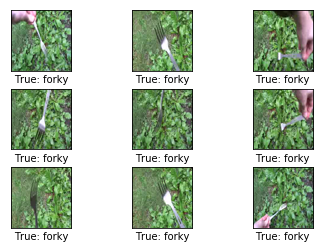

In [12]:
images=load_images(image_paths=image_paths_test[0:9])
cls_true=cls_test[0:9]
plot_images(images=images,cls_true=cls_true)

# download inception model

In [13]:
import download
from inception import transfer_values_cache
#inception.maybe_download() 
data_url = "http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz"
data_dir='inception'
download.maybe_download_and_extract(url=data_url, download_dir=data_dir)

Data has apparently already been downloaded and unpacked.


In [14]:
model = inception.Inception()

In [15]:
file_path_cache_train = os.path.join(data_dir, 'inception-knifey-train.pkl')
file_path_cache_test = os.path.join(data_dir, 'inception-knifey-test.pkl')

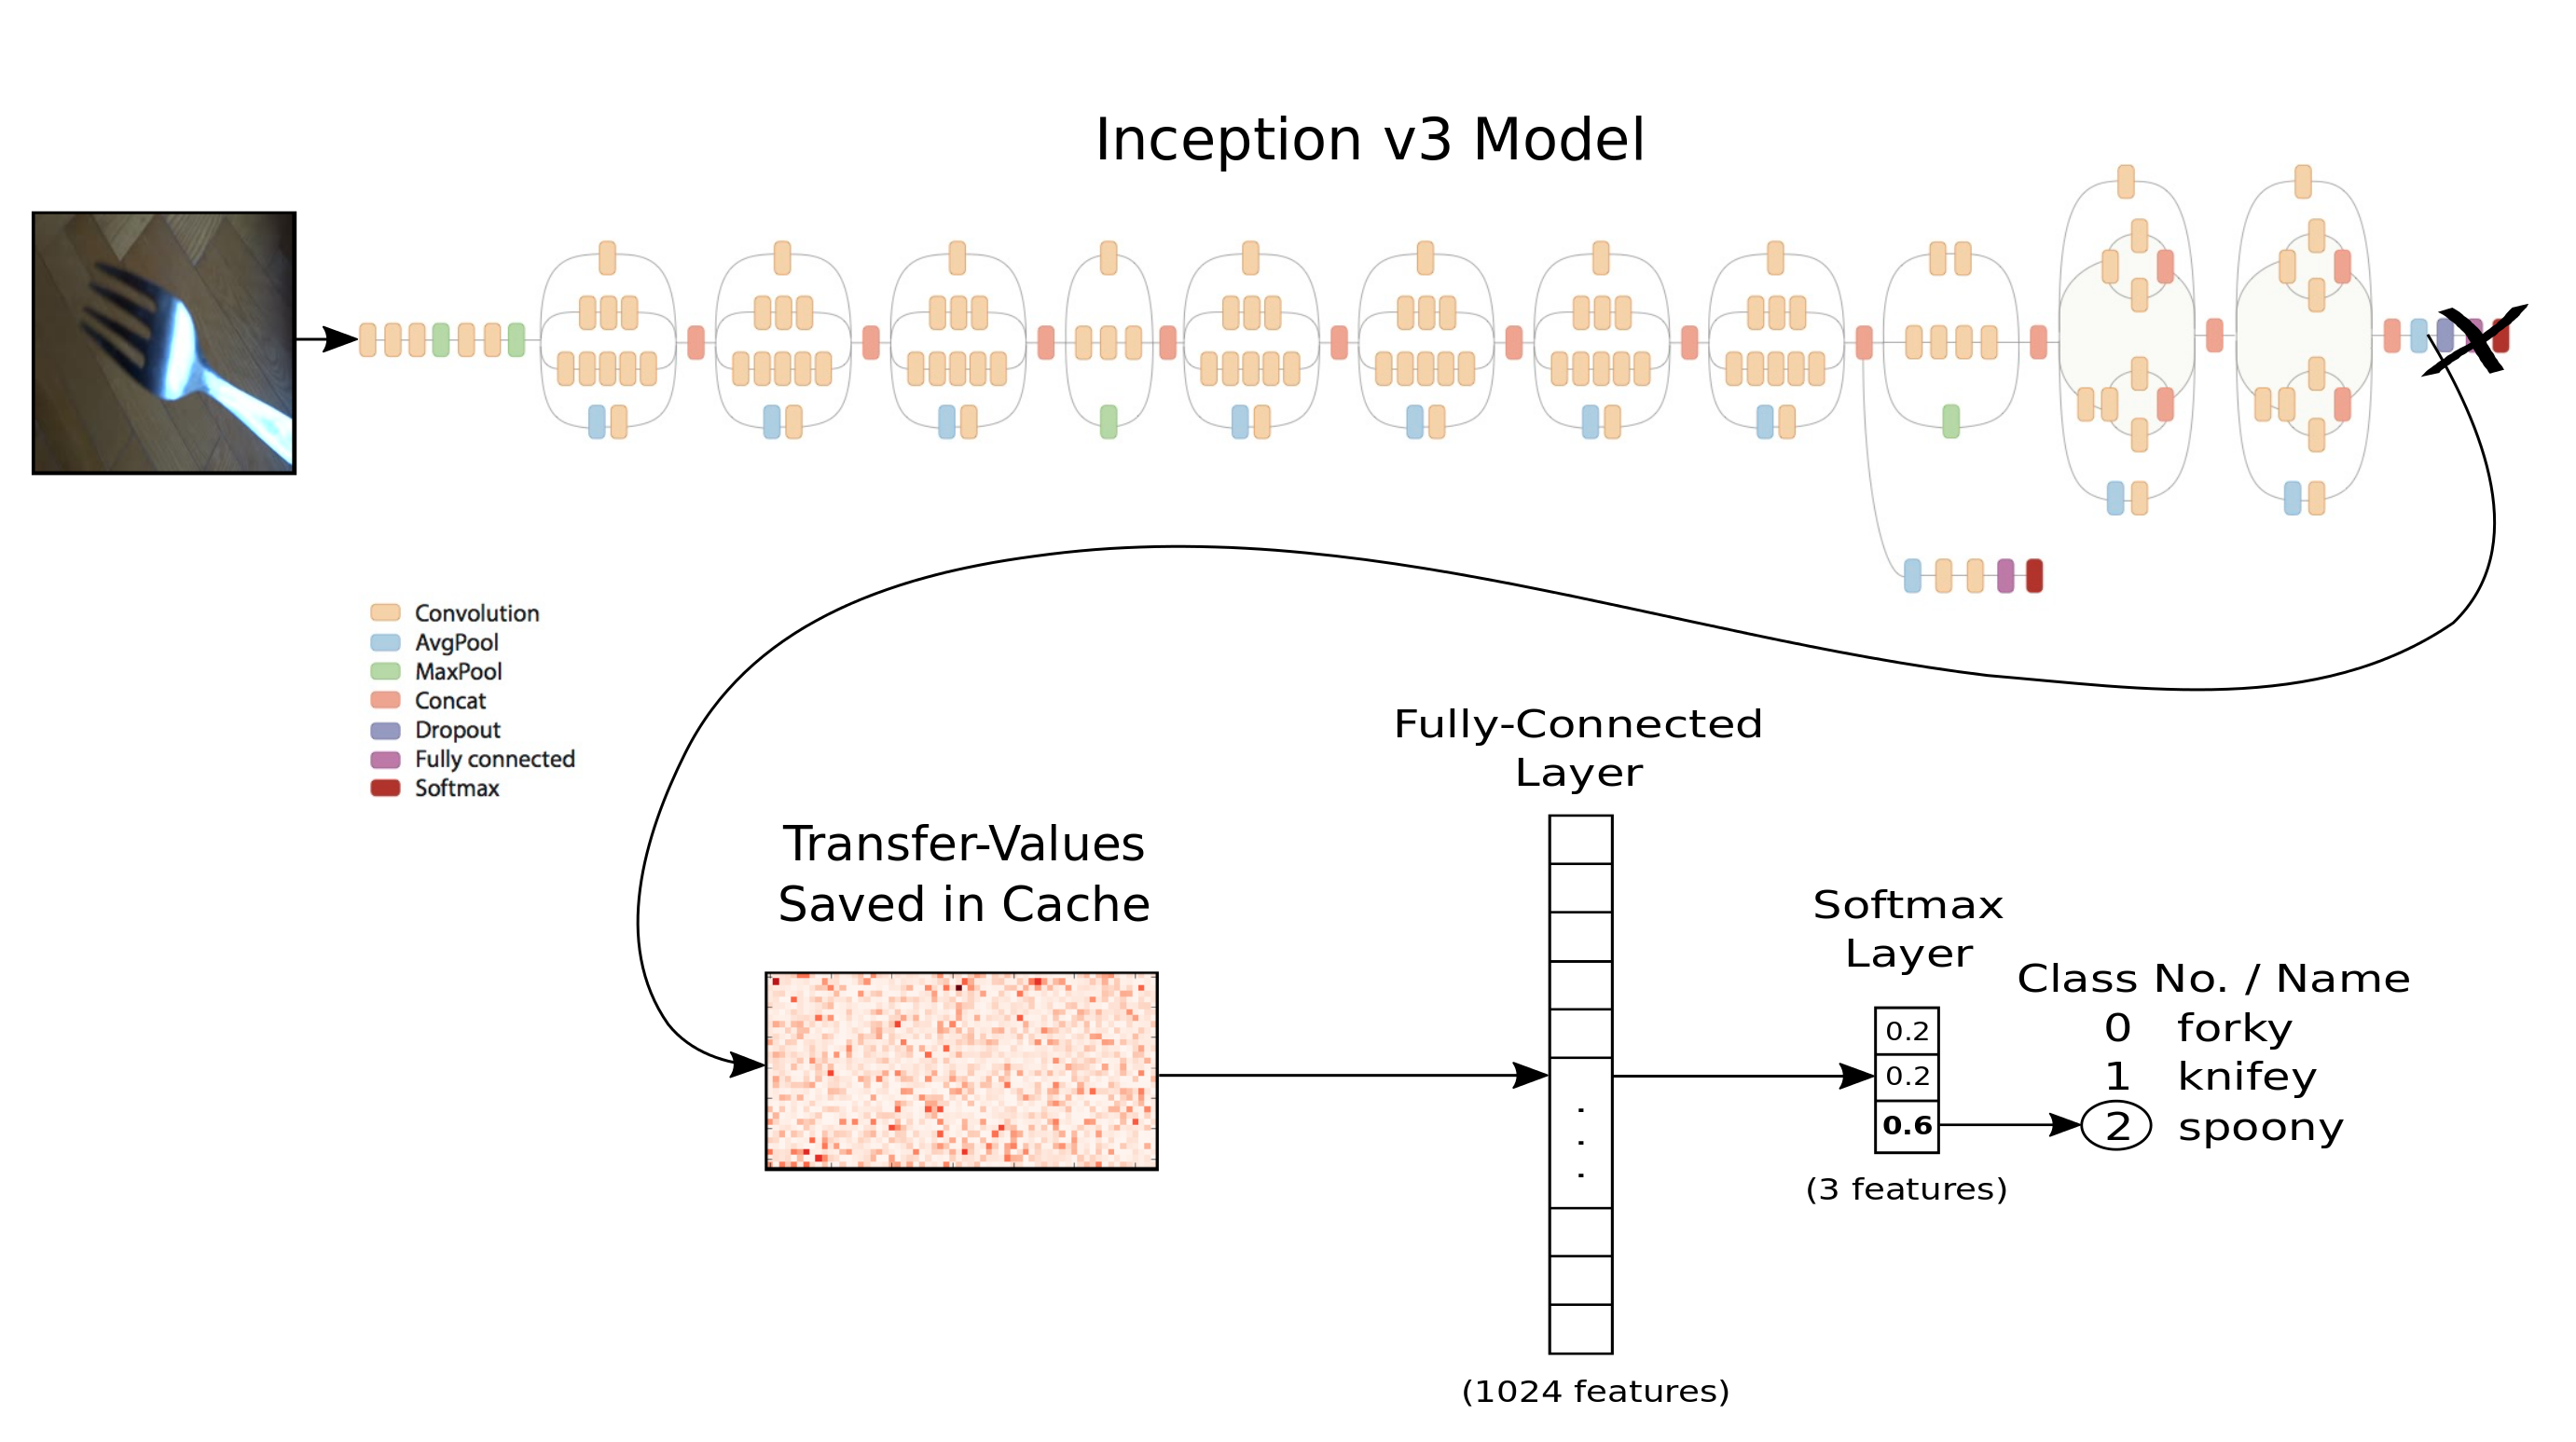

In [16]:
from IPython.display import Image
Image('images/09_transfer_learning_flowchart.png')

In [17]:
print("Processing Inception transfer-values for training-images ...")

# If transfer-values have already been calculated then reload them,
# otherwise calculate them and save them to a cache-file.
# transfer_values_cache(cache_path, model, images=None, image_paths=None) is defined in inception.py
transfer_values_train = transfer_values_cache(cache_path=file_path_cache_train,
                                              image_paths=image_paths_train,
                                              model=model)

Processing Inception transfer-values for training-images ...
- Data loaded from cache-file: inception/inception-knifey-train.pkl


In [18]:
print("Processing Inception transfer-values for test-images ...")

# If transfer-values have already been calculated then reload them,
# otherwise calculate them and save them to a cache-file.
transfer_values_test = transfer_values_cache(cache_path=file_path_cache_test,
                                             image_paths=image_paths_test,
                                             model=model)

Processing Inception transfer-values for test-images ...
- Data loaded from cache-file: inception/inception-knifey-test.pkl


In [19]:
transfer_values_train.shape

(4170, 2048)

In [20]:
transfer_values_test.shape

(530, 2048)

# Help functions

In [21]:
def plot_transfer_value(i):
    print('Input image:')
    image=imread(image_paths_test[i])
    plt.imshow(image,interpolation='nearest')
    print('Transfer-values for the image using Inception model:')
    plt.show()
    
    img = transfer_values_test[i]
    img = img.reshape((32, 64))
    plt.imshow(img,interpolation='nearest', cmap='binary') #'Reds'
    plt.show()

Input image:
Transfer-values for the image using Inception model:


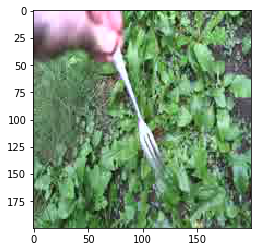

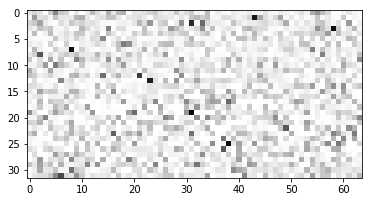

In [22]:
plot_transfer_value(0)

# Principal component anslysis (PCA)

In [23]:
from sklearn.decomposition import PCA

In [24]:
pca=PCA(n_components=2)

In [25]:
transfer_value = transfer_values_train
cls            = cls_train 

In [26]:
transfer_value.shape

(4170, 2048)

In [27]:
cls.shape

(4170,)

In [28]:
# reduce the dimension from 2048 to 2

transfer_value_reduce = pca.fit_transform(transfer_value)

In [29]:
transfer_value_reduce.shape

(4170, 2)

In [30]:
def plot_transfer_reduce(values,cls):
# Create a color-map with a different color for each class.
    import matplotlib.cm as cm
    cmap = cm.rainbow(np.linspace(0.0, 1.0, num_classes))
    idx=np.random.permutation(len(values))  # idx.shape=(4170,)
    colors=cmap[cls[idx]]      # different class with different color
    
    x=values[idx,0]     
    y=values[idx,1]
    plt.scatter(x,y,color=colors, alpha=0.5)
    plt.show()

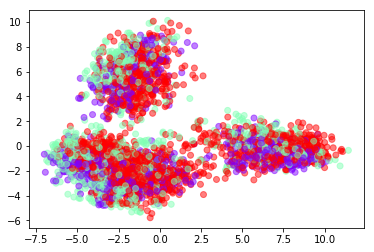

In [31]:
plot_transfer_reduce(transfer_value_reduce,cls)

# Analysis of Transfer-Values using t-SNE 

t-SNE: another way to do dimension reduction

- we first use PCA to reduce the transfer-values from 2048 to 50 elements.
- then use r-SNE to reduce into 2 dimension

In [32]:
from sklearn.manifold import TSNE

pca = PCA(n_components=50)
transfer_values_50d = pca.fit_transform(transfer_value)

In [33]:
tsne = TSNE(n_components=2)

transfer_values_reduced = tsne.fit_transform(transfer_values_50d) 

In [34]:
transfer_values_reduced.shape

(4170, 2)

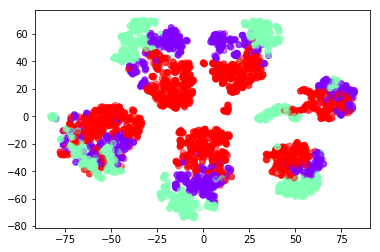

In [35]:
plot_transfer_reduce(transfer_values_reduced,cls)

In [36]:
def plot_transfer_reduce2(values,cls):
# Create a color-map with a different color for each class.
    import matplotlib.cm as cm
    cmap = cm.rainbow(np.linspace(0.0, 1.0, num_classes)) 
    colors=cmap[cls[:]]      # different class with different color
    x=values[:,0]     
    y=values[:,1]
    plt.scatter(x,y,color=colors, alpha=0.5)
    plt.show()

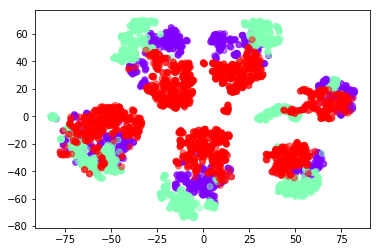

In [37]:
plot_transfer_reduce2(transfer_values_reduced,cls)

# create neural network

Now we will create another neural network in TensorFlow. This network will take as input the transfer-values from the Inception model and output the predicted classes for Knifey-Spoony images.

In [38]:
transfer_len = model.transfer_len
transfer_len

Dimension(2048)

In [39]:
x = tf.placeholder(tf.float32,shape=[None,transfer_len],name='x')
y_true = tf.placeholder(tf.float32,shape=[None,num_classes],name='y_true')
y_true_cls = tf.argmax(y_true,1)  # tf.argmax returns the index with the largest value

In [40]:
num_classes

3

# layer API

In [41]:
net = x

net = tf.layers.dense(inputs=net,name='layer_fc',
                    units=1024, activation=tf.nn.relu)

net = tf.layers.dense(inputs=net, name='layer_fc_out',
                      units=num_classes, activation=None)
logits = net 

y_pred = tf.nn.softmax(logits=logits)
y_pred_cls = tf.argmax(y_pred,1)

In [42]:
global_step = tf.Variable(initial_value=0,
                          name='global_step', trainable=False)

In [43]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=logits)

loss = tf.reduce_mean(cross_entropy)
 
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [44]:
y_pred_cls = tf.argmax(y_pred,1)

In [45]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [46]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [47]:
print(accuracy)

Tensor("Mean_1:0", shape=(), dtype=float32)


# tensfor flow

In [48]:
session = tf.Session()
session.run(tf.global_variables_initializer())
 

In [49]:
train_batch_size = 64

In [50]:
def random_batch():
    # Number of images (transfer-values) in the training-set.
    num_images = len(transfer_values_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random x and y-values.
    # We use the transfer-values instead of images as x-values.
    x_batch = transfer_values_train[idx]
    y_batch = labels_train[idx]

    return x_batch, y_batch

In [51]:
def optimize(num_iterations):
    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images (transfer-values) and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = random_batch()

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        # We also want to retrieve the global_step counter.
        i_global, _ = session.run([global_step, optimizer],
                                  feed_dict=feed_dict_train)

        # Print status to screen every 100 iterations (and last).
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            # Calculate the accuracy on the training-batch.
            batch_acc = session.run(accuracy,
                                    feed_dict=feed_dict_train)

            # Print status.
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [52]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)

    # Get the indices for the incorrectly classified images.
    idx = np.flatnonzero(incorrect)

    # Number of images to select, max 9.
    n = min(len(idx), 9)
    
    # Randomize and select n indices.
    idx = np.random.choice(idx,
                           size=n,
                           replace=False)

    # Get the predicted classes for those images.
    cls_pred = cls_pred[idx]

    # Get the true classes for those images.
    cls_true = cls_test[idx]

    # Load the corresponding images from the test-set.
    # Note: We cannot do image_paths_test[idx] on lists of strings.
    image_paths = [image_paths_test[i] for i in idx]
    images = load_images(image_paths)

    # Plot the images.
    plot_images(images=images,
                cls_true=cls_true,
                cls_pred=cls_pred)

In [53]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    # Print the confusion matrix as text.
    for i in range(num_classes):
        # Append the class-name to each line.
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))

In [54]:
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_cls(transfer_values, labels, cls_true):
    # Number of images.
    num_images = len(transfer_values)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images and labels
        # between index i and j.
        feed_dict = {x: transfer_values[i:j],
                     y_true: labels[i:j]}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j
        
    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    return correct, cls_pred

In [55]:
def predict_cls_test():
    return predict_cls(transfer_values = transfer_values_test,
                       labels = labels_test,
                       cls_true = cls_test)

In [56]:
def classification_accuracy(correct):
    # When averaging a boolean array, False means 0 and True means 1.
    # So we are calculating: number of True / len(correct) which is
    # the same as the classification accuracy.

    # Return the classification accuracy
    # and the number of correct classifications.
    return correct.mean(), correct.sum()

In [57]:
#correct, cls_pred = predict_cls_test()
#cls_pred

In [58]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # For all the images in the test-set,
    # calculate the predicted classes and whether they are correct.
    correct, cls_pred = predict_cls_test()
    
    # Classification accuracy and the number of correct classifications.
    acc, num_correct = classification_accuracy(correct)
    
    # Number of images being classified.
    num_images = len(correct)

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        #plot_example_errors(cls_pred=cls_pred, correct=correct)
        plot_example_errors(cls_pred, correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [ ]:
print_test_accuracy(show_example_errors=False,
                    show_confusion_matrix=True)

Accuracy on Test-Set: 32.1% (170 / 530)
Confusion Matrix:
[147   3   1] (0) forky
[113  23   1] (1) knifey
[238   4   0] (2) spoony
 (0) (1) (2)


In [ ]:
optimize(num_iterations=1000)

Global Step:    100, Training Batch Accuracy:  96.9%
Global Step:    200, Training Batch Accuracy:  96.9%
Global Step:    300, Training Batch Accuracy:  98.4%


In [ ]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)